In [1]:
# 지갑주소를 불러오기 위한 코드 생성 작업
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import requests
import json

import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # 이미지 불러오기
import pandas as pd

## TODO
1. 누적 PnL code
2. 현재 시점의 PnL code

## needs
1. 지갑정보를 통하여 현재 구매중인 데이터를 가지고 오는 코드
2. 지갑 정보를 통해 과거 데이터를 불러오는 코드
3. @문자가 들어가 있는 fetch코드를 통해 변환하는 함수

"0x5e57111634c43a8c376Fe5b9Bc39F60A4c8D6Ac6"

In [2]:
import requests
import json
import time

# API 엔드포인트
url = "https://api.hyperliquid.xyz/info"

# 요청 헤더
headers = {
    "Content-Type": "application/json"
}

# 요청 바디 (7일치 데이터 조회)
payload = {
    "type": "userFillsByTime",
    "user": "0x157a44b0555b31a0642fd0af47f6806d3b86ec9f",  # 유저 주소
    "startTime": 0 ,  # 7일 전
    "endTime": int(time.time() * 1000),  # 현재 시간
    "aggregateByTime": False
}

# API 호출
response = requests.post(url, headers=headers, data=json.dumps(payload))

# 응답 확인
if response.status_code == 200:
    fills = response.json()
    if fills:
        print("✅ 성공:", fills)
    else:
        print("✅ 성공: (하지만 거래 내역 없음) []")
else:
    print("❌ 오류:", response.status_code, response.text)

df = pd.DataFrame(fills)   

✅ 성공: [{'coin': '@123', 'px': '28.653', 'sz': '3.51', 'side': 'B', 'time': 1734102730078, 'startPosition': '0.0', 'dir': 'Buy', 'closedPnl': '0.0', 'hash': '0x4c9aae95c8346d0cc074041923d34f0202a400dc5e63e8160c6f539daf5633a0', 'oid': 55209150545, 'crossed': True, 'fee': '0.00122849', 'tid': 851173225398152, 'feeToken': 'FARM'}, {'coin': '@123', 'px': '28.653', 'sz': '3.47', 'side': 'B', 'time': 1734102731483, 'startPosition': '3.50877151', 'dir': 'Buy', 'closedPnl': '0.0', 'hash': '0xda75da38101e19c6fc27041923d3660201c7006166f0f27810ff557bdab55df2', 'oid': 55209161936, 'crossed': True, 'fee': '0.00121449', 'tid': 1083112195235921, 'feeToken': 'FARM'}, {'coin': '@123', 'px': '31.801', 'sz': '6.97', 'side': 'A', 'time': 1734103648684, 'startPosition': '6.97755702', 'dir': 'Sell', 'closedPnl': '21.871638', 'hash': '0x3e11557e4671e8412ee00419240bed02012a00f4f13ad82632e3968bdb8b81bf', 'oid': 55212811988, 'crossed': True, 'fee': '0.077578', 'tid': 868368664066349, 'feeToken': 'USDC'}, {'coin'

In [3]:
# UTC → KST 변환 함수
from datetime import datetime, timezone, timedelta

def convert_utc_to_kst(timestamp_ms):
    utc_time = datetime.fromtimestamp(timestamp_ms / 1000, tz=timezone.utc)
    kst_time = utc_time.astimezone(timezone(timedelta(hours=9)))
    
    return kst_time.strftime('%Y-%m-%d %H:%M:%S')

# 변환 적용
df["KST_Time"] = df["time"].apply(convert_utc_to_kst)
df.drop(['time'], axis=1, inplace=True)

In [4]:
import requests
import json
import pandas as pd

class CoinNamePreprocessing:
    def __init__(self, wallet_address):
        self.wallet_address = wallet_address

    def fetch_spot_meta(self):
        """Tname : coin name을 1:1로 매칭시키는 함수"""

        api_url = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}
        payload = {"type": 'spotMetaAndAssetCtxs'}

        response = requests.post(api_url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()

        data = response.json()

        tokens = pd.DataFrame(data[0]["tokens"]).rename(columns={"name": "Tname"})
        universe = pd.DataFrame(data[0]["universe"]).rename(columns={"name": "coin"})

        tokens = tokens.merge(universe, left_on="index", right_on="index", how="inner")
        return tokens

    def fetch_historical_orders(self, time_inverval, spot_only=False):
        # API 엔드포인트
        url = "https://api.hyperliquid.xyz/info"

        # 요청 헤더
        headers = {
          "Content-Type": "application/json"
        }   

        # 요청 바디 (최대 기간 조회)
        payload = {
            "type": "userFillsByTime",
            "user": self.wallet_address,  # 유저 주소
            "startTime": int(time.time() * 1000) - (1 * 86400000),  # 7일 전
            "endTime": int(time.time() * 1000),  # 현재 시간 기준
            "aggregateByTime": False
        }

        # API 호출
        response = requests.post(url, headers=headers, data=json.dumps(payload))

        # 응답 확인
        if response.status_code == 200:
            data = response.json()

            # API 응답에서 'fills' 키가 존재하는지 확인 후 데이터 추출
            
            # DataFrame 생성
            df = pd.DataFrame(data)

            # UTC 타임스탬프 변환
            if "time" in df.columns:
                df["Timestamp"] = pd.to_datetime(df["time"], unit="ms")
            else:
                print("⚠️ Warning: 'time' 컬럼이 없음")

            # Spot 또는 Perp 필터링
            if spot_only:  
                # Spot 거래만 필터링 (Coin 필드가 @로 시작하는 경우)
                filtered_df = df[df["coin"].str.startswith("@")].copy()

                # Spot 메타데이터 가져오기
                spot_meta = self.fetch_spot_meta()
                spot_meta1 = spot_meta[["Tname", "coin"]]

                # coin → Tname 변환 매핑
                coin_to_tname = dict(zip(spot_meta1["coin"], spot_meta1["Tname"]))

                # 변환 적용
                filtered_df["coin"] = filtered_df["coin"].map(coin_to_tname)

                # 존재하는 Tname 값만 유지
                filtered_df = filtered_df[filtered_df["coin"].isin(spot_meta1["Tname"].values)]

            else:
                # Perp 거래만 필터링 (Coin 필드가 @로 시작하지 않는 경우)
                filtered_df = df[~df["coin"].str.startswith("@")].copy()

            return filtered_df  # 필터링된 DataFrame 반환

        else:
            # API 응답 실패 시 오류 메시지 출력
            print(" 오류:", response.status_code, response.text)
            return pd.DataFrame()  # 빈 DataFrame 반환

####################################################################################################  
# 실행 예제
wallet_address = "0x8e096995c3e4a3f0bc5b3ea1cba94de2aa4d70c9" # 지갑 주소 입력
coin_processor = CoinNamePreprocessing(wallet_address)

# 지갑 정보에 대한 주문내역 가져오기
df_orders = coin_processor.fetch_historical_orders(time_inverval=, spot_only=False)

SyntaxError: invalid syntax (2523330533.py, line 98)

In [5]:
    import requests
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    import time

    class CoinNamePreprocessing:
        def __init__(self, wallet_address):
            self.wallet_address = wallet_address

        def fetch_spot_meta(self):
            """Tname : coin name을 1:1로 매칭시키는 함수"""

            api_url = "https://api.hyperliquid.xyz/info"
            headers = {"Content-Type": "application/json"}
            payload = {"type": 'spotMetaAndAssetCtxs'}

            response = requests.post(api_url, headers=headers, data=json.dumps(payload))
            response.raise_for_status()

            data = response.json()

            tokens = pd.DataFrame(data[0]["tokens"]).rename(columns={"name": "Tname"})
            universe = pd.DataFrame(data[0]["universe"]).rename(columns={"name": "coin"})

            tokens = tokens.merge(universe, left_on="index", right_on="index", how="inner")
            return tokens

        def fetch_and_plot_pnl(self, time_interval=7, coin_name="HYPE", spot_only=False):
            """
            1. 특정 기간(time_interval)의 거래 내역을 불러오고
            2. closedPnl을 float로 변환 후 코인별 누적 PnL을 계산
            3. 특정 코인(coin_name)에 대해 필터링하여 그래프로 시각화
            """
            # API 엔드포인트
            url = "https://api.hyperliquid.xyz/info"

            # 요청 헤더
            headers = {"Content-Type": "application/json"}   

            # 요청 바디 (최대 기간 조회)
            payload = {
                "type": "userFillsByTime",
                "user": self.wallet_address,  # 유저 주소
                "startTime": int(time.time() * 1000) - (time_interval * 86400000),  # 지정된 기간 전부터 조회
                "endTime": int(time.time() * 1000),  # 현재 시간 기준
                "aggregateByTime": False
            }

            # API 호출
            response = requests.post(url, headers=headers, data=json.dumps(payload))

            # 응답 확인
            if response.status_code != 200:
                print("오류:", response.status_code, response.text)
                return pd.DataFrame()  # 빈 DataFrame 반환

            data = response.json()

            # DataFrame 생성
            df = pd.DataFrame(data)

            # UTC 타임스탬프 변환
            if "time" in df.columns:
                df["Timestamp"] = pd.to_datetime(df["time"], unit="ms")
            else:
                print("⚠️ Warning: 'time' 컬럼이 없음")
                return pd.DataFrame()

            # Spot 또는 Perp 필터링
            if spot_only:
                filtered_df = df[df["coin"].str.startswith("@")].copy()

                # Spot 메타데이터 가져오기
                spot_meta = self.fetch_spot_meta()
                spot_meta1 = spot_meta[["Tname", "coin"]]

                # coin → Tname 변환 매핑
                coin_to_tname = dict(zip(spot_meta1["coin"], spot_meta1["Tname"]))

                # 변환 적용
                filtered_df["coin"] = filtered_df["coin"].map(coin_to_tname)

                # 존재하는 Tname 값만 유지
                filtered_df = filtered_df[filtered_df["coin"].isin(spot_meta1["Tname"].values)]
            else:
                filtered_df = df[~df["coin"].str.startswith("@")].copy()

            # closedPnl을 float로 변환
            filtered_df["closedPnl"] = pd.to_numeric(filtered_df["closedPnl"], errors="coerce").fillna(0.0)

            # 코인별 누적 PnL 계산
            filtered_df["Cumulative PnL"] = filtered_df.groupby("coin")["closedPnl"].cumsum()

            # 특정 코인 필터링
            sample = filtered_df[(filtered_df["closedPnl"] > 0) & (filtered_df["coin"] == coin_name)]
            sample.reset_index(drop=True, inplace=True)
            
            if np.mean(sample["Cumulative PnL"])>0: # 양수인 경우 up 이미지 입히기
                fig, ax = plt.subplots(figsize=(10, 5))

                fig.patch.set_facecolor("#11191D")
                img = plt.imread("/Users/ijongseung/pnlc/up.jpeg")
                ax.imshow(img, aspect='auto', extent=[sample["Timestamp"].min(), sample["Timestamp"].max(), sample["Cumulative PnL"].min(), sample["Cumulative PnL"].max()], alpha=0.5)
                ax.tick_params(axis='both', colors='white')

                # 데이터 플롯
                ax.plot(sample["Timestamp"], sample["Cumulative PnL"], marker='o', linestyle='-', color='blue', label=f"{coin_name} Cumulative PnL", alpha=0.5)
                ax.set_xlabel("Timestamp", color='white')
                ax.set_ylabel("Cumulative PnL", color = 'white')
                ax.set_title(f"{coin_name} {time_interval}-day Cumulative PnL", color = "white")
                ax.legend()
                ax.grid()
                # x축 포맷 설정 (가독성 개선)
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  # X축 눈금 개수 제한
                plt.xticks(rotation=45)  # X축 레이블 회전
                plt.show()
            
            else:
                fig, ax = plt.subplots(figsize=(10, 5))
                
                fig.patch.set_facecolor("#F6CECE")
                img = plt.imread("/Users/ijongseung/pnlc/down.jpeg")
                ax.imshow(img, aspect='auto', extent=[sample["Timestamp"].min(), sample["Timestamp"].max(), sample["Cumulative PnL"].min(), sample["Cumulative PnL"].max()], alpha=0.5)
                ax.tick_params(axis='both', colors='black')

                # 데이터 플롯
                ax.plot(sample["Timestamp"], sample["Cumulative PnL"], marker='o', linestyle='-', color='red', label=f"{coin_name} Cumulative PnL", alpha=0.5)
                ax.set_xlabel("Timestamp")
                ax.set_ylabel("Cumulative PnL")
                ax.set_title(f"{coin_name} {time_interval}-day Cumulative PnL")
                ax.legend()
                ax.grid()
                ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))  # X축 눈금 개수 제한
                plt.xticks(rotation=45)  # X축 레이블 회전
                plt.show()

            return filtered_df  # 결과 DataFrame 반환

    ####################################################################################################  
    # 실행 예제
    wallet_address = "0x157a44b0555b31a0642fd0af47f6806d3b86ec9f"  # 지갑 주소 입력
    coin_processor = CoinNamePreprocessing(wallet_address)

    # 특정 코인 (예: HYPE) 에 대한 누적 PnL 그래프 + 배경 이미지
    df_orders = coin_processor.fetch_and_plot_pnl(
        time_interval=1, 
        coin_name="HYPE", 
        spot_only=False, # False이면 선물거래만 보겠다는 의미
    )

⚠️ Warning: 'time' 컬럼이 없음


### 해당 근거를 가지고 데이터 수집

In [42]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import numpy as np

class CoinNamePreprocessing:
    def __init__(self, wallet_address):
        self.wallet_address = wallet_address

    def fetch_spot_meta(self):
        api_url = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}
        payload = {"type": 'spotMetaAndAssetCtxs'}
        
        response = requests.post(api_url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        
        data = response.json()
        
        tokens = pd.DataFrame(data[0]["tokens"]).rename(columns={"name": "Tname"})
        universe = pd.DataFrame(data[0]["universe"]).rename(columns={"name": "coin"})
        
        tokens = tokens.merge(universe, left_on="index", right_on="index", how="inner")
        return tokens
    
    def fetch_and_plot_pnl(self, time_interval=7, coin_name="HYPE", spot_only=False):
        url = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}   
        
        payload = {
            "type": "userFillsByTime",
            "user": self.wallet_address,
            "startTime": int(time.time() * 1000) - (time_interval * 86400000),
            "endTime": int(time.time() * 1000),
            "aggregateByTime": False
        }
        
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        
        if response.status_code != 200:
            print("오류:", response.status_code, response.text)
            return pd.DataFrame()
        
        data = response.json()
        df = pd.DataFrame(data)
        
        if "time" in df.columns:
            df["Timestamp"] = pd.to_datetime(df["time"], unit="ms")
        else:
            print("⚠️ Warning: 'time' 컬럼이 없음")
            return pd.DataFrame()
        
        if spot_only:
            filtered_df = df[df["coin"].str.startswith("@")] .copy()
            spot_meta = self.fetch_spot_meta()
            spot_meta1 = spot_meta[["Tname", "coin"]]
            coin_to_tname = dict(zip(spot_meta1["coin"], spot_meta1["Tname"]))
            filtered_df["coin"] = filtered_df["coin"].map(coin_to_tname)
            filtered_df = filtered_df[filtered_df["coin"].isin(spot_meta1["Tname"].values)]
            
        else:
            filtered_df = df[~df["coin"].str.startswith("@")] .copy()
        
        filtered_df["closedPnl"] = pd.to_numeric(filtered_df["closedPnl"], errors="coerce").fillna(0.0)
        filtered_df["Cumulative PnL"] = filtered_df.groupby("coin")["closedPnl"].cumsum()
        
        sample = filtered_df[(filtered_df["closedPnl"] > 0) & (filtered_df["coin"] == coin_name)]
        sample.reset_index(drop=True, inplace=True)
        
        if sample.empty:
            print(f"No data available for {coin_name}")
            return filtered_df

        # Plot customization for dark theme with smooth green line
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(10, 5))

        x = sample["Timestamp"]
        y = sample["Cumulative PnL"]

        # Smooth the line
        x_smooth = np.linspace(0, len(x) - 1, 300)
        y_smooth = np.interp(x_smooth, np.arange(len(x)), y)

        ax.plot(x_smooth, y_smooth, color='#00FFAA', linewidth=2.5)

        ax.set_facecolor("#11191D")
        ax.tick_params(axis='both', colors='white')
        ax.set_xlabel("Timestamp", color='white')
        ax.set_ylabel("Cumulative PnL", color='white')
        ax.set_title(f"{coin_name} {time_interval}-day Cumulative PnL", color='white')

        ax.grid(color='#444444', linestyle='--', linewidth=0.5)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
        plt.xticks(rotation=45)
        plt.show()
        
        return filtered_df

In [51]:
# 실행 예제
wallet_address = "0x157a44b0555b31a0642fd0af47f6806d3b86ec9f"  
coin_processor = CoinNamePreprocessing(wallet_address)

df_orders = coin_processor.fetch_and_plot_pnl(
    time_interval=10, 
    coin_name="", 
    spot_only=False
)

No data available for 


In [52]:
df_orders

,coin,px,sz,side,time,startPosition,dir,closedPnl,hash,oid,crossed,fee,tid,feeToken,liquidation,Timestamp,Cumulative PnL
0,TST,0.29938,1003.0,A,1739125386095,0.0,Open Short,0.000000,0x531e2c8ee9429f3dd2ec041d73b91d02012200577f8c...,71001675526,True,0.100893,906045550344894,USDC,NaN,2025-02-09 18:23:06.095,0.000000
1,TST,0.25137,1003.0,B,1739133357986,-1003.0,Close Short,48.154030,0x13f416becd0eb9252e95041d75335b0202160018571b...,71020116237,True,0.084713,12977443119180,USDC,NaN,2025-02-09 20:35:57.986,48.154030
2,HYPE,23.021,10.85,A,1739134026289,661.79,Close Long,0.603260,0xecebc6a466ad88701957041d7553d801c6000a66e33f...,71021917860,True,0.083925,865737817271378,USDC,NaN,2025-02-09 20:47:06.289,0.603260
3,HYPE,23.017,8.57,A,1739134026289,650.94,Close Long,0.442212,0xecebc6a466ad88701957041d7553d801c6000a66e33f...,71021917860,True,0.066277,434283628552401,USDC,NaN,2025-02-09 20:47:06.289,1.045472
4,HYPE,23.013,25.17,A,1739134026289,642.37,Close Long,1.198092,0xecebc6a466ad88701957041d7553d801c6000a66e33f...,71021917860,True,0.194623,744258001023058,USDC,NaN,2025-02-09 20:47:06.289,2.243564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,HYPE,25.787,5.0,A,1739795680710,107.97,Close Long,-0.719500,0xf89e600a29306604982d041dee605601a5007d68791c...,72893267031,True,0.043321,952017011474488,USDC,NaN,2025-02-17 12:34:40.710,1858.057598
976,HYPE,25.786,38.78,A,1739795680710,102.97,Close Long,-5.619222,0xf89e600a29306604982d041dee605601a5007d68791c...,72893267031,True,0.335993,430212214931800,USDC,NaN,2025-02-17 12:34:40.710,1852.438376
977,HYPE,25.782,26.92,A,1739795680710,64.19,Close Long,-4.008388,0xf89e600a29306604982d041dee605601a5007d68791c...,72893267031,True,0.233201,83989261902211,USDC,NaN,2025-02-17 12:34:40.710,1848.429988
978,HYPE,25.781,37.27,A,1739795680710,37.27,Close Long,-5.586773,0xf89e600a29306604982d041dee605601a5007d68791c...,72893267031,True,0.322848,1115324157162880,USDC,NaN,2025-02-17 12:34:40.710,1842.843215


In [133]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import time
import numpy as np
from scipy.interpolate import CubicSpline

class CoinNamePreprocessing:
    def __init__(self, wallet_address):
        self.wallet_address = wallet_address

    def fetch_spot_meta(self):
        api_url = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}
        payload = {"type": 'spotMetaAndAssetCtxs'}
        
        response = requests.post(api_url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        
        data = response.json()
        
        tokens = pd.DataFrame(data[0]["tokens"]).rename(columns={"name": "Tname"})
        universe = pd.DataFrame(data[0]["universe"]).rename(columns={"name": "coin"})
        
        tokens = tokens.merge(universe, left_on="index", right_on="index", how="inner")
        return tokens
    
    def fetch_and_plot_total_pnl(self, time_interval=7, spot_only=False):
        url = "https://api.hyperliquid.xyz/info"
        headers = {"Content-Type": "application/json"}   
        
        payload = {
            "type": "userFillsByTime",
            "user": self.wallet_address,
            "startTime": int((pd.Timestamp.now() - pd.Timedelta(days=time_interval)).timestamp() * 1000),
            "endTime": int(pd.Timestamp.now().timestamp() * 1000),
            "aggregateByTime": False
        }
        
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        
        if response.status_code != 200:
            print("오류:", response.status_code, response.text)
            return pd.DataFrame()
        
        data = response.json()
        df = pd.DataFrame(data)
        
        # Ensure 'time' column exists and is correctly parsed
        time_column = next((col for col in df.columns if 'time' in col.lower()), None)
        if time_column:
            df["Timestamp"] = pd.date_range(end=pd.Timestamp.now(), periods=len(df), freq='D')  # Generate daily dates
        else:
            print("⚠️ Warning: No valid time column found")
            return pd.DataFrame()
        
        if spot_only:
            filtered_df = df[df["coin"].str.startswith("@")] .copy()
            spot_meta = self.fetch_spot_meta()
            spot_meta1 = spot_meta[["Tname", "coin"]]
            coin_to_tname = dict(zip(spot_meta1["coin"], spot_meta1["Tname"]))
            filtered_df["coin"] = filtered_df["coin"].map(coin_to_tname)
            filtered_df = filtered_df[filtered_df["coin"].isin(spot_meta1["Tname"].values)]
        else:
            filtered_df = df[~df["coin"].str.startswith("@")] .copy()
        
        filtered_df["closedPnl"] = pd.to_numeric(filtered_df["closedPnl"], errors="coerce").fillna(0.0)
        
        # Calculate cumulative PnL for all coins combined
        filtered_df.sort_values(by="Timestamp", inplace=True)
        filtered_df = filtered_df.drop_duplicates(subset="Timestamp")  # Remove duplicates
        filtered_df["Cumulative PnL"] = filtered_df["closedPnl"].cumsum()
        
        if filtered_df.empty:
            print("No data available")
            return filtered_df

        # Ensure x is strictly increasing
        if not filtered_df["Timestamp"].is_monotonic_increasing:
            filtered_df = filtered_df.sort_values("Timestamp")

        # Plot customization for dark theme with cubic spline smoothing
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(10, 5))

        x = filtered_df["Timestamp"]
        y = filtered_df["Cumulative PnL"]

        # Cubic Spline Smoothing with Date Formatting
        x_numeric = mdates.date2num(x)
        cs = CubicSpline(x_numeric, y)

        x_smooth = np.linspace(x_numeric.min(), x_numeric.max(), 300)
        y_smooth = cs(x_smooth)

        # Gradient fill below line
        ax.plot(mdates.num2date(x_smooth), y_smooth, color='#00FFAA', linewidth=2.5)
        ax.fill_between(mdates.num2date(x_smooth), y_smooth, color='#00FFAA', alpha=0.2)

        # Display dates on x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        ax.set_facecolor("#11191D")
        ax.tick_params(axis='both', colors='white')
        ax.set_xlabel("Date", color='white')
        ax.set_ylabel("Cumulative PnL", color='white')

        if time_interval == 3:
            ax.set_title(f"24H Cumulative PnL", color='white')
        else:
            ax.set_title(f"Total {time_interval-2}-day Cumulative PnL", color='white')

        ax.grid(color='#444444', linestyle='--', linewidth=0.5)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
        plt.xticks(rotation=45)
        plt.show()
        
        return filtered_df


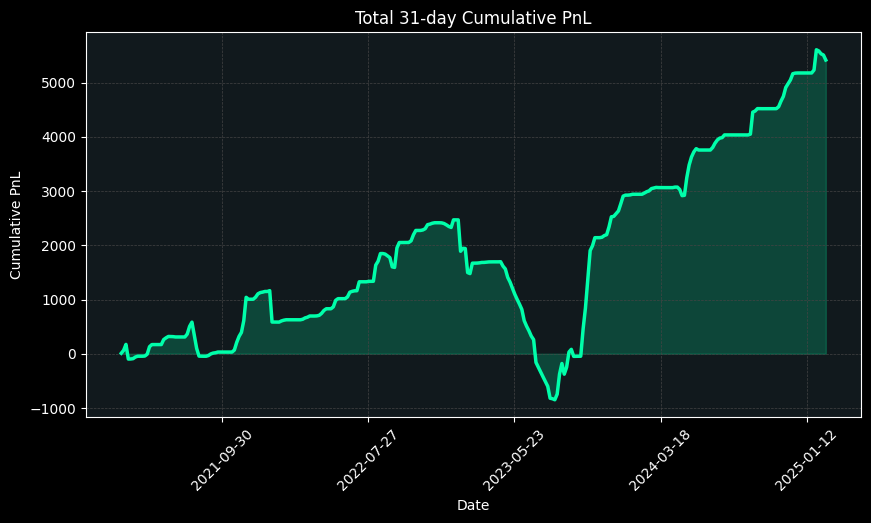

In [134]:
wallet_address = "0x157a44b0555b31a0642fd0af47f6806d3b86ec9f"  
coin_processor = CoinNamePreprocessing(wallet_address)

df_orders = coin_processor.fetch_and_plot_total_pnl(
    time_interval=33, # 24H : 3 / 1week : 9 / 1month : 33
    # coin_name="HYPE", 
    spot_only=False
)